# Notebook 12 Sentiment Predictive Model for the Aspect Dataset

This notebook seeks to train a model to predict sentiment on the full dataset based only on the noun phrases previously extracted.

* Section 1 - Import libraries and data
* Section 2 - Data preprocessing
* Section 3 - Building a sentiment model (Models 1 to 5 based on the best simple networks from Notebook 8)
* Section 4 - Summary results

Datasets need to run file:
* combined_sentiment.csv
* combined_sentiment_test.csv

Models saved to:
* SentimentModels1
* SentimentModels2
* SentimentModels3
* SentimentModels4
* SentimentModels5

Final results:

* results_sentiment.csv


# Section 1: Import libraries and data

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE

import os
import pickle

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [18]:
# Bring in training and test sets from Notebook 11 (visualising topic models)
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

In [19]:
# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(72932, 15)

# Section 2: Data preprocessing

In [21]:
# Choose columns, replace incorrect category label and relabel columns
df_train = df_train[["OrigInd","Category","noun_phrases","Topic Count","Sentiment","Score"]]
df_train.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]
df_test = df_test[["OrigInd","Category","noun_phrases","Topic","Sentiment","Score"]]
df_test["Category"].replace({"Attract": "Attractions"}, inplace=True)
df_test.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]

In [23]:
# Get Category distribution
df_combined_all["Category"].value_counts()

Food             40557
Accommodation    24638
Attractions       7527
Attract            210
Name: Category, dtype: int64

In [32]:
df_combined_all.head(2)

,Unnamed: 0.1,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF,Sentiment,Score,Sentence,Topic
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation,"['shame', 'accommodation']",Entertainment&Activities,Entertainment,-0.4767,1,NaN,NaN
3,3,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",would never not really sure expect review eith...,good terrible,['terrible'],Food,Food,-0.0516,1,NaN,NaN


In [26]:
# Get Polarity distribution
df_combined_all["Score"].value_counts()

neutral     38994
positive    29512
negative     4426
Name: Score, dtype: int64

<BarContainer object of 3 artists>

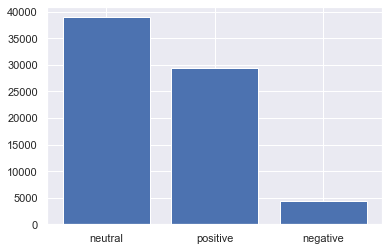

In [28]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

The dataset is imbalanced

In [29]:
# Drop the neutral sentiment and set 0 to positive and 1 to negative
df_combined_all = df_combined_all[df_combined_all["Score"]!="neutral"]
df_combined_all["Score"].replace({"positive": 0,"negative":1}, inplace=True)

In [34]:
df_combined_all.to_csv("combinedall.csv")

## Define X and y and split into training, valuation and test sets

In [109]:
X = df_combined["Noun Phrases"]
y = df_combined["Polarity"]

In [110]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, random_state=42) 

In [111]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(27140,) (3393,) (3393,) (27140,) (3393,) (3393,)


In [112]:
y_train.value_counts()

0    23606
1     3534
Name: Polarity, dtype: int64

In [113]:
y_val.value_counts()

0    2951
1     442
Name: Polarity, dtype: int64

In [114]:
y_test.value_counts()

0    2951
1     442
Name: Polarity, dtype: int64

## Distribution of noun phrases

<AxesSubplot:title={'center':'Distribution of Number of Words/Noun'}, ylabel='Frequency'>

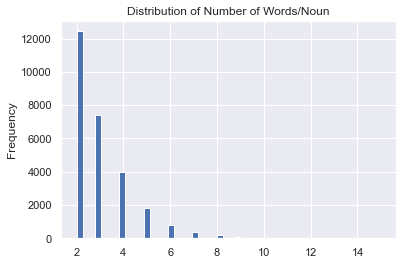

In [117]:
pd.DataFrame(X_train)["Noun Phrases"].str.split().apply(len).plot.hist(bins = 50, title = "Distribution of Number of Words/Noun")

In [118]:
pd.DataFrame(X_train)["Noun Phrases"].str.split().apply(len).max()

15

## Encoding X values

In [119]:
num_words = 6000
maxlen = 20
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [120]:
index_word = {v:k for k,v in tokenizer.word_index.items()}

In [121]:
#print(tokenizer.word_counts)

In [122]:
#print(tokenizer.word_index)

In [123]:
X_train_s = tokenizer.texts_to_sequences(X_train)
X_val_s = tokenizer.texts_to_sequences(X_val)
X_test_s = tokenizer.texts_to_sequences(X_test)

In [124]:
X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=maxlen, padding="post", truncating="post", value=0.0)
X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=maxlen, padding="post", truncating="post", value=0.0 )
X_test_w = pad_sequences(np.array(X_test_s,dtype = "object"), maxlen = maxlen, padding = "post",truncating = "post",value = 0.0)

In [125]:
X_train_w[1]

array([ 1, 12, 27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

# Section 3: Building a Sentiment Model

In [126]:
# Visualise the training and test accuracies and losses
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()

In [127]:
# Confusion Matrix function

def class_conf(y_val,y_pred_class):
    classification = classification_report(y_val, y_pred_class)
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred_class)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    print(classification)  

## Sentiment Model 1

In [128]:
# Metrics function

def metric_results(y_val,y_pred_class):
    accuracy = accuracy_score(y_val, y_pred_class)
    rocauc = roc_auc_score(y_val,y_pred_class)
    precision = precision_score(y_val, y_pred_class, average='binary')
    recall = recall_score(y_val, y_pred_class, average='binary')
    f1 = f1_score(y_val, y_pred_class, average='binary')
          
    
    results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
    return results

In [129]:
# Balanced classes - get weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights

array([0.57485385, 3.83984154])

In [205]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 8
epochs = 50
class_weights = {0:0.57485385,
                 1:3.83984154}

In [206]:
# Simple model with embedding layer and no hidden dense layer, passing the embedding layer to the first layer of the model
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [136]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_6 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 321       
Total params: 96,321
Trainable params: 96,321
Non-trainable params: 0
_________________________________________________________________
None


In [137]:
# The model will use earlystopping if the valuation loss doesn't decrease after 3 epochs
output_dir = 'model_output/SentimentModels1'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [138]:
# Model using keras embeddings
history = model.fit(X_train_w,y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.2266 - accuracy: 0.9157 - val_loss: 0.0710 - val_accuracy: 0.9761
Epoch 2/50
3393/3393 - 2s - loss: 0.0489 - accuracy: 0.9850 - val_loss: 0.0383 - val_accuracy: 0.9882
Epoch 3/50
3393/3393 - 2s - loss: 0.0224 - accuracy: 0.9940 - val_loss: 0.0324 - val_accuracy: 0.9888
Epoch 4/50
3393/3393 - 2s - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.0379 - val_accuracy: 0.9867
Epoch 5/50
3393/3393 - 2s - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0276 - val_accuracy: 0.9900
Epoch 6/50
3393/3393 - 2s - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0287 - val_accuracy: 0.9906
Epoch 7/50
3393/3393 - 2s - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0350 - val_accuracy: 0.9885
Epoch 8/50
3393/3393 - 2s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0336 - val_accuracy: 0.9897
Epoch 9/50
3393/3393 - 2s - loss: 9.7095e-04 - accuracy: 0.9997 - val_loss: 0.0343 - val_accuracy: 0.9894
Epoch 10/50
3393/3393 - 2s - loss: 7.1174e-04 - accuracy: 0.9998 - val_loss: 0

In [139]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Validation Accuracy:  0.9894


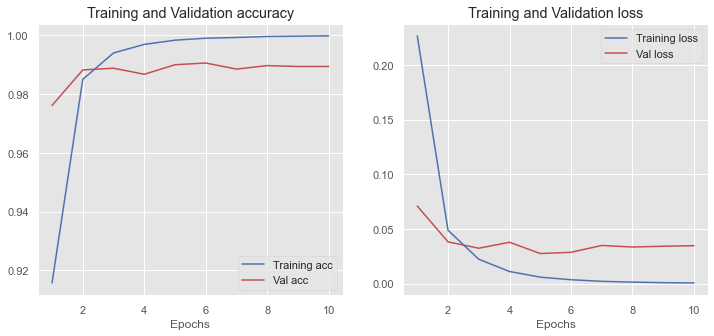

In [140]:
plot_history(history)

In [141]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.06.hdf5")

In [142]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [143]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.9999032],[1],1
1,[3.9698187e-09],[0],0
2,[5.2715994e-05],[0],0
3,[1.3584706e-09],[0],0
4,[0.4658544],[0],0


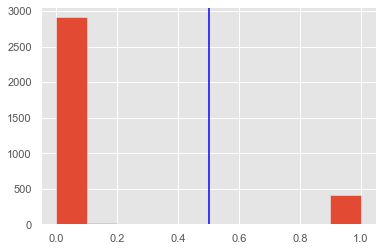

In [144]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2951
           1       0.97      0.96      0.96       442

    accuracy                           0.99      3393
   macro avg       0.98      0.98      0.98      3393
weighted avg       0.99      0.99      0.99      3393



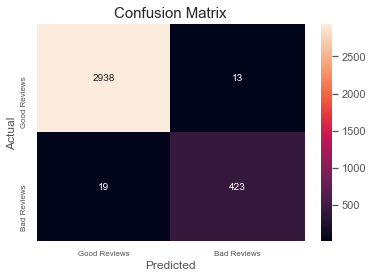

In [145]:
# Print metrics
class_conf(y_val,y_pred_class)

In [146]:
# Summarised results
model1 = metric_results(y_val,y_pred_class)
model1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.990569,0.970183,0.957014,0.963554,0.976304


High accuracy but recall on the low side

## Sentiment Model 2

In [147]:
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(64, activation='relu', input_shape=(1600,)))
model.add(Dense(1, activation='sigmoid'))

In [148]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_7 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                20544     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 116,609
Trainable params: 116,609
Non-trainable params: 0
_________________________________________________________________
None


In [149]:
output_dir = 'model_output/SentimentModels2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [150]:
# Model using keras embeddings
history = model.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.1451 - accuracy: 0.9419 - val_loss: 0.0470 - val_accuracy: 0.9823
Epoch 2/50
3393/3393 - 2s - loss: 0.0255 - accuracy: 0.9916 - val_loss: 0.0312 - val_accuracy: 0.9882
Epoch 3/50
3393/3393 - 2s - loss: 0.0061 - accuracy: 0.9977 - val_loss: 0.0282 - val_accuracy: 0.9923
Epoch 4/50
3393/3393 - 2s - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0372 - val_accuracy: 0.9909
Epoch 5/50
3393/3393 - 2s - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0398 - val_accuracy: 0.9909
Epoch 6/50
3393/3393 - 2s - loss: 7.4216e-04 - accuracy: 0.9996 - val_loss: 0.0470 - val_accuracy: 0.9900
Epoch 7/50
3393/3393 - 2s - loss: 9.9459e-04 - accuracy: 0.9996 - val_loss: 0.0463 - val_accuracy: 0.9894
Epoch 8/50
3393/3393 - 2s - loss: 5.0584e-04 - accuracy: 0.9999 - val_loss: 0.0537 - val_accuracy: 0.9894


In [151]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9998
Testing Accuracy:  0.9894


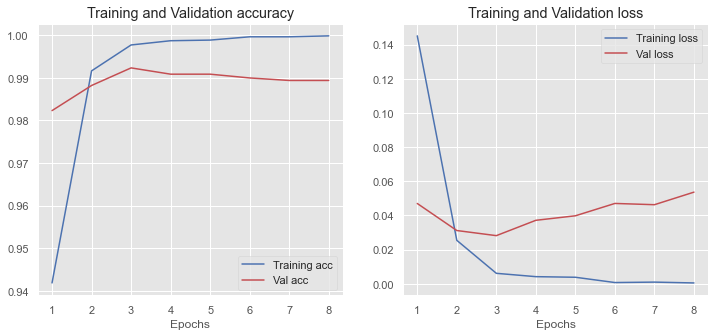

In [152]:
plot_history(history)

In [153]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.03.hdf5")

In [154]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [155]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.9999481],[1],1
1,[2.9650694e-08],[0],0
2,[2.1083813e-05],[0],0
3,[5.6221644e-08],[0],0
4,[0.4817678],[0],0


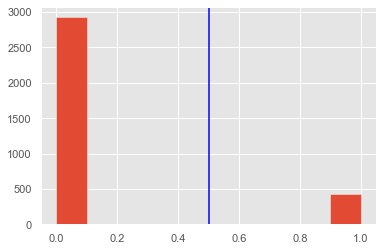

In [156]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2951
           1       0.97      0.97      0.97       442

    accuracy                           0.99      3393
   macro avg       0.98      0.98      0.98      3393
weighted avg       0.99      0.99      0.99      3393



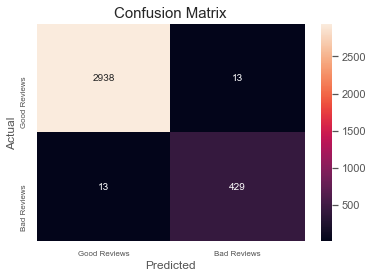

In [157]:
# Print metrics
class_conf(y_val,y_pred_class)

In [158]:
# Summarised results
model2 = metric_results(y_val,y_pred_class)
model2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.992337,0.970588,0.970588,0.970588,0.983091


Accuracy still very good and recall improved

## Sentiment Model 3

In [159]:
# Network with a hidden layer with more neurons in the dense layer and with dropout of 50%
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid')) 

In [160]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_8 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               41088     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
None


In [161]:
output_dir = 'model_output/SentimentModels3'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [162]:
# Model using keras embeddings
history = model.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.1515 - accuracy: 0.9324 - val_loss: 0.0696 - val_accuracy: 0.9752
Epoch 2/50
3393/3393 - 2s - loss: 0.0276 - accuracy: 0.9920 - val_loss: 0.0289 - val_accuracy: 0.9909
Epoch 3/50
3393/3393 - 2s - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 4/50
3393/3393 - 2s - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.0437 - val_accuracy: 0.9903
Epoch 5/50
3393/3393 - 2s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0487 - val_accuracy: 0.9894
Epoch 6/50
3393/3393 - 2s - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0504 - val_accuracy: 0.9915
Epoch 7/50
3393/3393 - 2s - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0537 - val_accuracy: 0.9900


In [163]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9996
Testing Accuracy:  0.9900


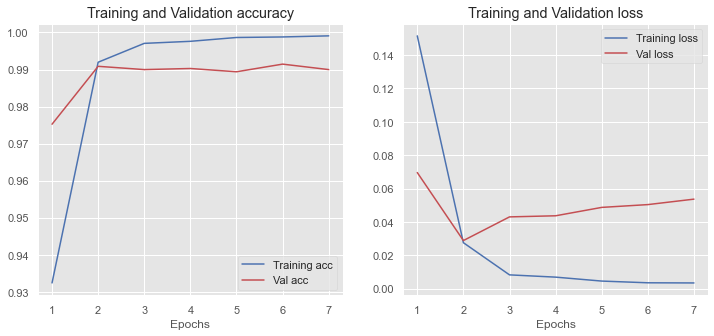

In [164]:
plot_history(history)

In [165]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.06.hdf5")

In [166]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [167]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[1.0],[1],1
1,[1.1007388e-15],[0],0
2,[5.3304893e-07],[0],0
3,[2.7018985e-13],[0],0
4,[0.0289855],[0],0


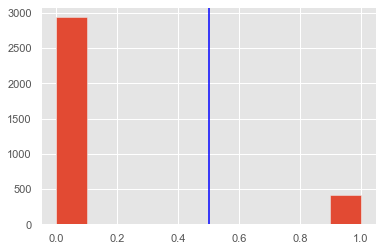

In [168]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2951
           1       0.97      0.96      0.97       442

    accuracy                           0.99      3393
   macro avg       0.98      0.98      0.98      3393
weighted avg       0.99      0.99      0.99      3393



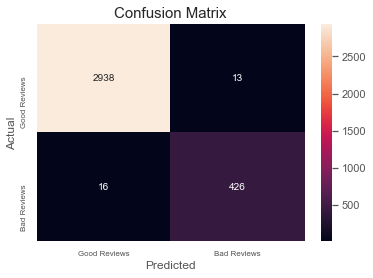

In [169]:
# Print metrics
class_conf(y_val,y_pred_class)

In [170]:
# Summarised results
model3 = metric_results(y_val,y_pred_class)
model3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.991453,0.970387,0.963801,0.967083,0.979698


Accuracy and recall slightly reduced on the previous model

## Sentiment Model 4

In [171]:
# Dense model with 2 hidden dense layers and dropout on each
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation='sigmoid')) 

In [172]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 16)            96000     
_________________________________________________________________
flatten_9 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               41088     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [173]:
output_dir = 'model_output/SentimentModels4'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [174]:
# Model using keras embeddings
history = model.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 2s - loss: 0.1660 - accuracy: 0.9399 - val_loss: 0.0474 - val_accuracy: 0.9847
Epoch 2/50
3393/3393 - 2s - loss: 0.0320 - accuracy: 0.9924 - val_loss: 0.0419 - val_accuracy: 0.9879
Epoch 3/50
3393/3393 - 2s - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.0592 - val_accuracy: 0.9867
Epoch 4/50
3393/3393 - 2s - loss: 0.0090 - accuracy: 0.9979 - val_loss: 0.0531 - val_accuracy: 0.9876
Epoch 5/50
3393/3393 - 2s - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0557 - val_accuracy: 0.9906
Epoch 6/50
3393/3393 - 2s - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.1068 - val_accuracy: 0.9826
Epoch 7/50
3393/3393 - 2s - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.0469 - val_accuracy: 0.9912


In [175]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9993
Testing Accuracy:  0.9912


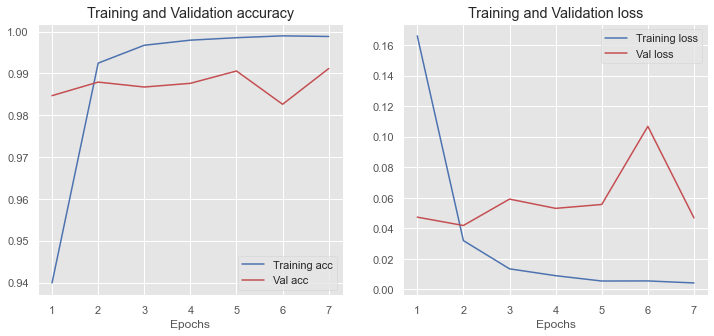

In [176]:
plot_history(history)

In [177]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.07.hdf5")

In [178]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [179]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[0.9999995],[1],1
1,[8.574475e-20],[0],0
2,[5.644906e-10],[0],0
3,[1.1379466e-25],[0],0
4,[0.00033190846],[0],0


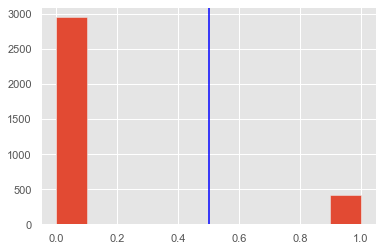

In [180]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2951
           1       0.98      0.95      0.97       442

    accuracy                           0.99      3393
   macro avg       0.99      0.97      0.98      3393
weighted avg       0.99      0.99      0.99      3393



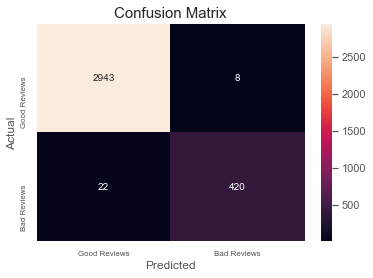

In [181]:
# Print metrics
class_conf(y_val,y_pred_class)

In [182]:
# Summarised results
model4 = metric_results(y_val,y_pred_class)
model4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.991158,0.981308,0.950226,0.965517,0.973758


No real change to accuracy and recall reduced further

##  Sentiment Model 5

In [183]:
# Dense model with 2 hidden dense layers and dropout on each
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(1, activation='sigmoid')) 

In [184]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 16)            96000     
_________________________________________________________________
flatten_10 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               164352    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)             

In [185]:
output_dir = 'model_output/SentimentModels5'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]

In [186]:
# Model using keras embeddings
history = model.fit(X_train_w, y_train,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val),
                    batch_size=batch_size,class_weight = class_weights)

Epoch 1/50
3393/3393 - 4s - loss: 0.1619 - accuracy: 0.9447 - val_loss: 0.0365 - val_accuracy: 0.9861
Epoch 2/50
3393/3393 - 4s - loss: 0.0367 - accuracy: 0.9922 - val_loss: 0.0467 - val_accuracy: 0.9882
Epoch 3/50
3393/3393 - 3s - loss: 0.0133 - accuracy: 0.9969 - val_loss: 0.0579 - val_accuracy: 0.9885
Epoch 4/50
3393/3393 - 3s - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.0801 - val_accuracy: 0.9894
Epoch 5/50
3393/3393 - 4s - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.0763 - val_accuracy: 0.9891
Epoch 6/50
3393/3393 - 3s - loss: 0.0075 - accuracy: 0.9986 - val_loss: 0.0977 - val_accuracy: 0.9882


In [187]:
# Print training and test accuracies
loss, accuracy = model.evaluate(X_train_w, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val_w, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9992
Testing Accuracy:  0.9882


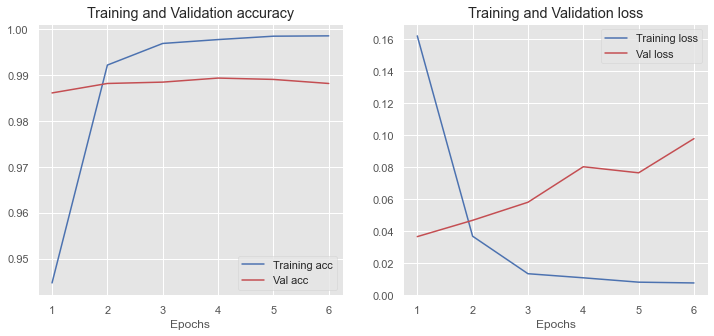

In [188]:
plot_history(history)

In [189]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.04.hdf5")

In [190]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_w)
y_pred_class = (model.predict(X_val_w) > 0.5).astype("int32")

In [191]:
# Create dataframe with y pred probabilities, classes and y actual
ydf = pd.DataFrame(list(zip(y_pred_prob, y_pred_class,y_val,)), columns=['y_prob','y_pred_class', 'y'])
ydf.head()

,y_prob,y_pred_class,y
0,[1.0],[1],1
1,[5.9369156e-21],[0],0
2,[4.1593146e-11],[0],0
3,[4.3874828e-23],[0],0
4,[0.081876904],[0],0


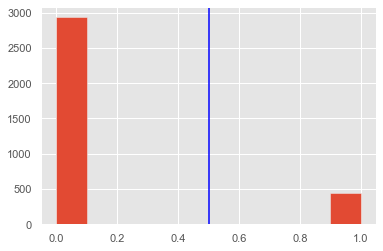

In [192]:
# Graph to show distribution of probabilities produced by the model
plt.hist(y_pred_prob)
_ = plt.axvline(x=0.5, color='blue')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2951
           1       0.96      0.96      0.96       442

    accuracy                           0.99      3393
   macro avg       0.97      0.98      0.98      3393
weighted avg       0.99      0.99      0.99      3393



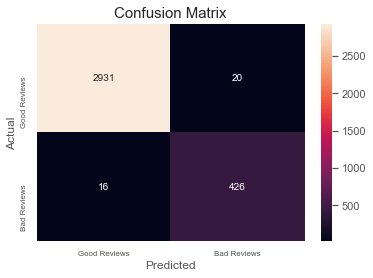

In [193]:
# Print metrics
class_conf(y_val,y_pred_class)

In [194]:
# Summarised results
model5 = metric_results(y_val,y_pred_class)
model5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.98939,0.955157,0.963801,0.959459,0.978512


No improvements in accuracy and recall

# Section 4: Summary of results

In [197]:
models = ["Model1","Model2","Model3","Model4","Model5"]
summary_table = pd.concat([model1,model2,model3,model4,model5])
summary_table.set_index([models],inplace = True)
summary_table.to_csv("results_sentiment.csv")
summary_table.sort_values(by = "Recall",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Model2,0.992337,0.970588,0.970588,0.970588,0.983091
Model3,0.991453,0.970387,0.963801,0.967083,0.979698
Model5,0.989390,0.955157,0.963801,0.959459,0.978512
Model1,0.990569,0.970183,0.957014,0.963554,0.976304
Model4,0.991158,0.981308,0.950226,0.965517,0.973758


The model that has the best accuracy and recall is Model 2, which is a network with one dense layer. This is in effect a simple binary text classification task, so it is perhaps not surprising that a simple model works fairly well.